In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %%capture
# !pip install pafy youtube-dl moviepy

In [3]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Using Seed Constant to get consistent result on every execution.

In [4]:
seed_constant=27
np.random.seed(seed=seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed=seed_constant)

## Visualizing the UCF50 Dataset

In [11]:
#Create a Matplotlib figure and specify size of fidure
plt.figure(figsize=(20,20))
# # Get the current working directory
# current_directory = os.getcwd()

# # List all items in the current directory
# all_items = os.listdir('')

# #Get class names
all_classes_names=os.listdir('drive/MyDrive/MyDataset')
all_classes_names
# all_items


['HighJump', 'PullUps', 'TaiChi', 'PushUps', 'Punch']

<Figure size 2000x2000 with 0 Axes>

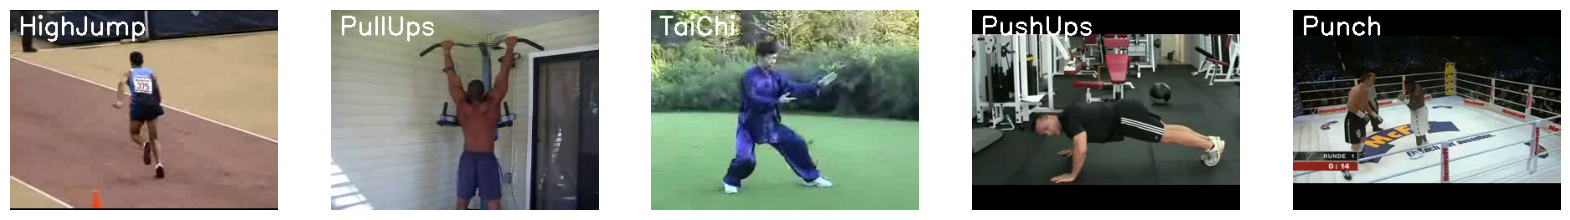

In [12]:
# Increase the figure size to make subplots larger
plt.figure(figsize=(20, 10))
for i in range(len(all_classes_names)):
    selected_class_name=all_classes_names[i]

    video_file_names=os.listdir(f'drive/MyDrive/MyDataset/{selected_class_name}')

    selected_video_file_name=random.choice(video_file_names)

    video_reader=cv2.VideoCapture(f'drive/MyDrive/MyDataset/{selected_class_name}/{selected_video_file_name}')

    _,bgr_frame=video_reader.read()
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(1, 5, i+1)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Preprocessing Data

In [18]:
#Dimension of each video frame
IMAGE_HEIGHT,IMAGE_WIDTH=64,64

#Sequence frame
SEQUENCE_LENGTH=20

DATASET_DIR='drive/MyDrive/MyDataset'

CLASSES_LIST=['HighJump','Punch']

# Feature Extraction

In [19]:
def feature_extraction(video_path):
    #list to store video frames
    frames_list=[]

    #Read Video
    video_reader=cv2.VideoCapture(video_path)
    #count frames
    video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    #Iterate through Video Frames.

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    return frames_list


# Dataset Creation

In [20]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    features=[]
    labels=[]
    video_files_paths=[]
    for class_id,class_name in enumerate(CLASSES_LIST):
        print(f"Extracting Features from {class_name}")
        files_list=os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_path=os.path.join(DATASET_DIR, class_name, file_name)
            frames=feature_extraction(video_path)

            #check if extracted frames meet sequence length criteria
            if(len(frames)==SEQUENCE_LENGTH):
                features.append(frames)
                labels.append(class_id)
                video_files_paths.append(video_path)
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [21]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Features from HighJump
Extracting Features from Punch


One hot encoding labels

In [22]:
one_hot_encoded_labels=to_categorical(labels)

# Split Data into Train and Test

In [23]:
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

# Implement ConvLSTM

In [24]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [25]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [ ]:
%%capture

%pip install pydot


In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Compile and Train model

In [26]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
43/43 [==============================] - 28s 433ms/step - loss: 0.4310 - accuracy: 0.8107 - val_loss: 0.3509 - val_accuracy: 0.7907
Epoch 2/50
43/43 [==============================] - 18s 422ms/step - loss: 0.2772 - accuracy: 0.8639 - val_loss: 0.6620 - val_accuracy: 0.6977
Epoch 3/50
43/43 [==============================] - 18s 411ms/step - loss: 0.3209 - accuracy: 0.8757 - val_loss: 0.1536 - val_accuracy: 0.9767
Epoch 4/50
43/43 [==============================] - 18s 409ms/step - loss: 0.2249 - accuracy: 0.8994 - val_loss: 0.3288 - val_accuracy: 0.8140
Epoch 5/50
43/43 [==============================] - 17s 405ms/step - loss: 0.1720 - accuracy: 0.9467 - val_loss: 0.3944 - val_accuracy: 0.8140
Epoch 6/50
43/43 [==============================] - 17s 404ms/step - loss: 0.1480 - accuracy: 0.9408 - val_loss: 0.3073 - val_accuracy: 0.8605
Epoch 7/50
43/43 [==============================] - 17s 399ms/step - loss: 0.1268 - accuracy: 0.9527 - val_loss: 0.1619 - val_accuracy: 0.9302

In [27]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

3/3 [==============================] - 1s 160ms/step - loss: 0.2408 - accuracy: 0.9437


In [28]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [29]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

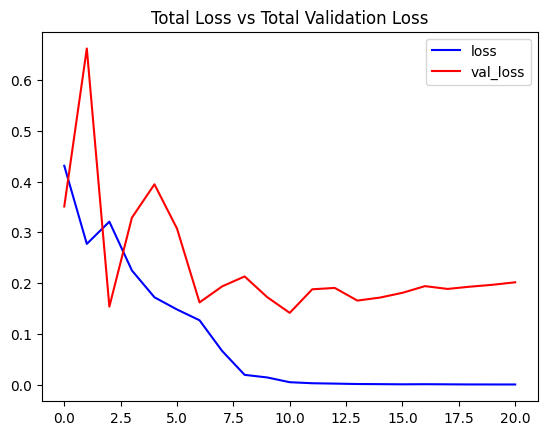

In [30]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

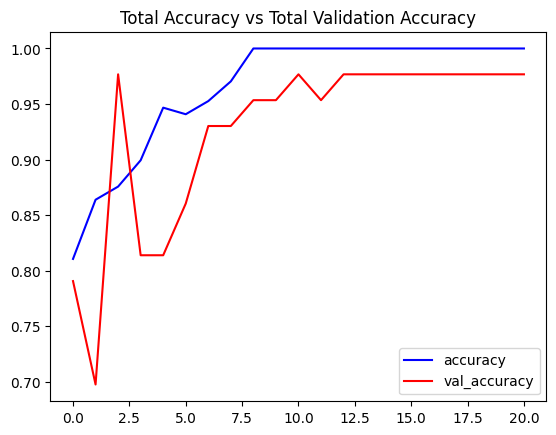

In [31]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')